In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import shutil 
from tqdm import tqdm
import os
import torchvision
import matplotlib.pyplot as plt
import seaborn as sns
import time
import copy
import random
import subprocess
from PIL import Image
from Code.CustomResnet18 import CustomResnet18
from Code.CustomMobilenetv3small import CustomMobilenetv3small
from Code.OnnxModel import OnnxModel
from PIL import Image
from torchvision import transforms, models
import cv2

seed = 77
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [2]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

dataset source: https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset

# Load datasets

C:\Users\IlshatGuestAccount\AppData\Local\Temp\ipykernel_14784\4028007105.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_counts, x='Class', y='Image Count', palette='Set2')


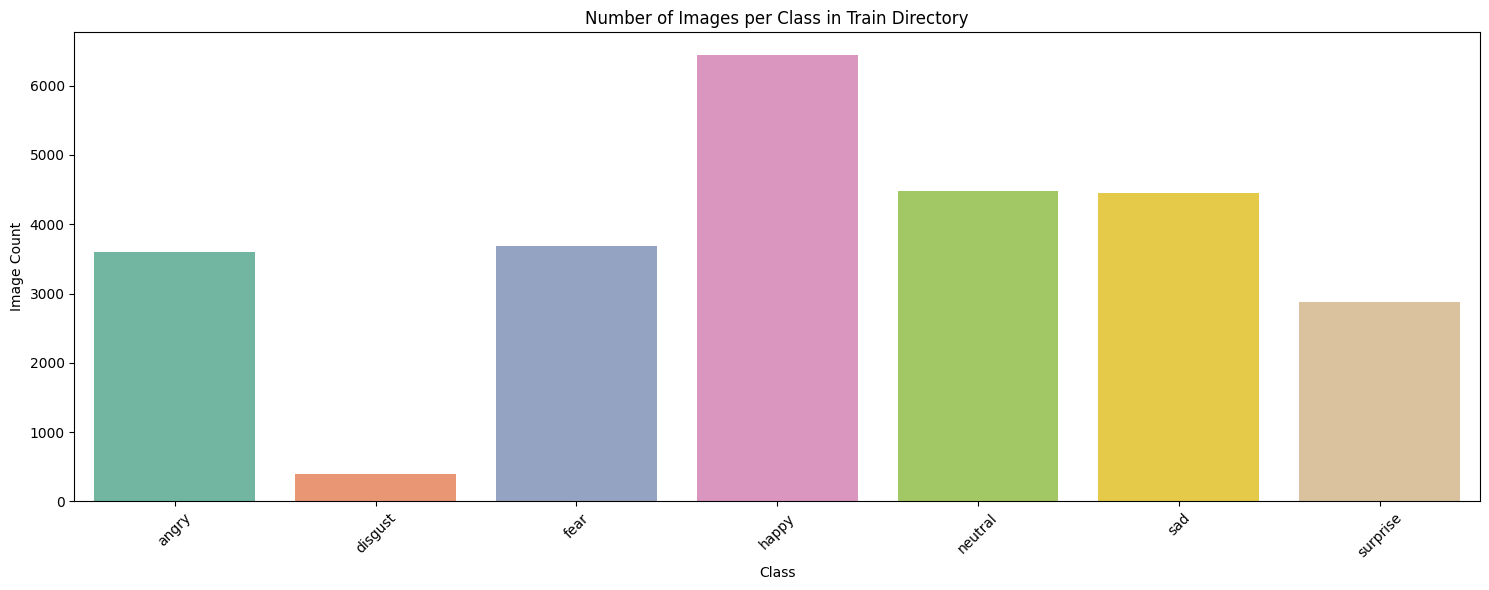

{'angry': 3594,
 'disgust': 393,
 'fear': 3693,
 'happy': 6448,
 'neutral': 4484,
 'sad': 4445,
 'surprise': 2885}

In [3]:
class_counts = {}
train_dir = os.path.join('fed2013', 'train')

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        count = len(os.listdir(class_path))
        class_counts[class_name] = count

# Convert to DataFrame
df_counts = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Image Count'])

# Plot using Seaborn
plt.figure(figsize=(15, 6))
sns.barplot(data=df_counts, x='Class', y='Image Count', palette='Set2')
plt.title("Number of Images per Class in Train Directory")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
class_counts

In [4]:
import shutil
import random


# to make test dataset, validation dataset we already have
test_path = os.path.join('fed2013', 'test')
test_size = 0.1
main_data_path = os.path.join('fed2013', 'train')

if not os.path.isdir(test_path):
    for emotion_class in os.listdir(main_data_path):
        files = os.listdir(os.path.join(main_data_path, emotion_class))
        n_files = len(files)
        random_subsample = random.sample(files, int(n_files*test_size))
        test_class_path = os.path.join(test_path, emotion_class)
        os.makedirs(test_class_path, exist_ok=True)
        for file in random_subsample:
            shutil.move(os.path.join(main_data_path, emotion_class, file), os.path.join(test_class_path, file))

In [5]:
# # calculate images' mean and std
# runn_mean = 0
# runn_std = 0
# total_files = 0
# for root, dirs, files in os.walk(os.path.join('fed2013', 'train')):
#     total_files+=len(files)
#     for file in files:
#         img = cv2.imread(os.path.join(root, file), cv2.IMREAD_GRAYSCALE)
#         runn_mean+=(img / 255.0).mean()
#         runn_std+=(img / 255.0).std()
# mean = runn_mean / total_files
# std = runn_std / total_files

# print('mean {} std {}'.format(mean, std))

In [6]:
# # fix image distribution's disbalance
# from torchvision.utils import save_image

# augm_transform = transforms.Compose([
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.RandomAdjustSharpness(1.3, p = 0.5),
#     transforms.ToTensor()
# ])

# root = os.path.join('fed2013', 'train')
# max_images_per_class = max(class_counts.values())
# for folder in os.listdir(root):
#     folder_dest = os.path.join(root, folder)
#     files = os.listdir(folder_dest)
#     for _ in range(max_images_per_class - len(files)):
#         file = files[random.randint(0, len(files)-1)]
#         img = Image.open(os.path.join(folder_dest, file))
#         augm_img = augm_transform(img)
#         img_name, ext = file.split('.')
#         new_img_name = img_name+f'_{random.randint(1,10000)}.'+ ext
#         save_image(augm_img, os.path.join(folder_dest, new_img_name))

In [7]:
img_size = (224, 224)
mean = [0.508]
std = [0.255]

augm_transforms = torch.nn.ModuleList([
                   transforms.RandomRotation((-10, 10)),
                   transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.1, hue=0.1)
                  ])

train_transform = transforms.Compose([
                        transforms.Grayscale(num_output_channels=1),
                        transforms.Resize(img_size, interpolation=transforms.InterpolationMode.BICUBIC),
                        transforms.RandomHorizontalFlip(p=0.5),
                        transforms.RandomApply(augm_transforms, p=0.5),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=mean, std=std)
                   ])

valtest_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(img_size, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [8]:
root_data_dir = 'fed2013'
train_dir = os.path.join(root_data_dir, 'train')
val_dir = os.path.join(root_data_dir, 'validation')
test_dir = os.path.join(root_data_dir, 'test')
train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transform)

val_dataset = torchvision.datasets.ImageFolder(val_dir, valtest_transform)

test_dataset = torchvision.datasets.ImageFolder(test_dir, valtest_transform)

In [9]:
class_names = list(os.listdir(train_dir))

In [10]:
batch_size = 64
num_workers = 4
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# EDA

In [11]:
print("train size : {} val size : {} test size {}".format(len(train_dataloader), len(val_dataloader), len(test_dataloader)))

train size : 406 val size : 111 test size 45


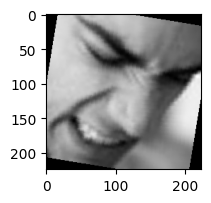

In [12]:
batch_data, batch_labels = next(iter(train_dataloader))
fig, ax = plt.subplots(figsize=(2,4))
plt.imshow(batch_data[0].permute(1, 2, 0).numpy(), cmap='gray');

In [13]:
batch_data[0].shape

torch.Size([1, 224, 224])

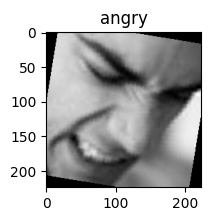

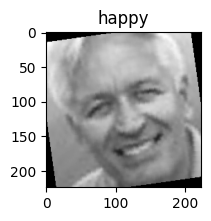

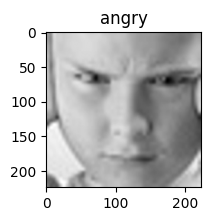

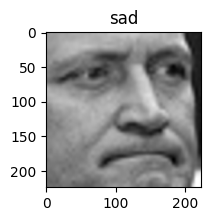

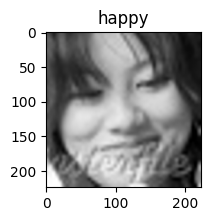

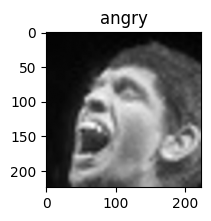

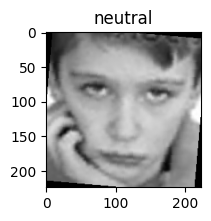

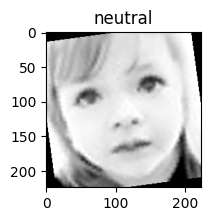

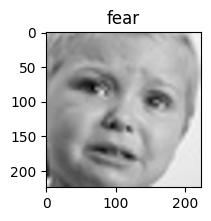

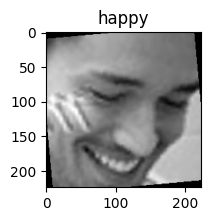

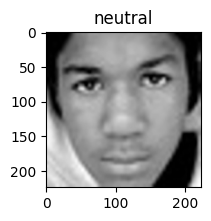

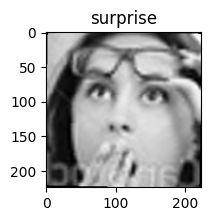

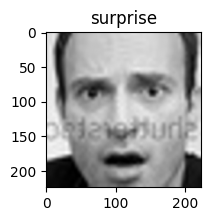

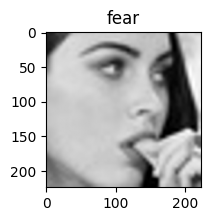

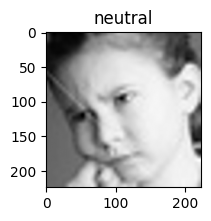

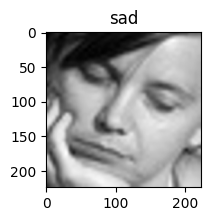

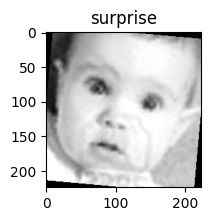

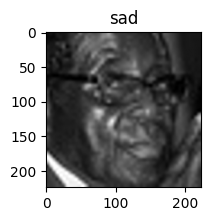

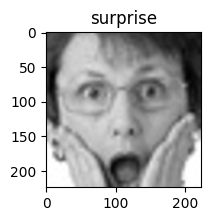

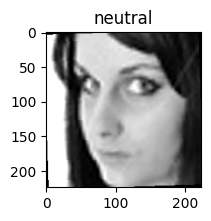

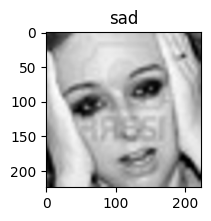

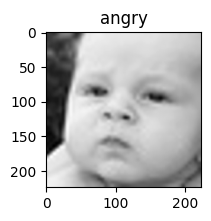

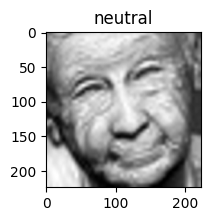

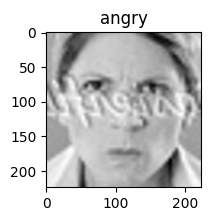

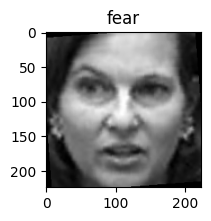

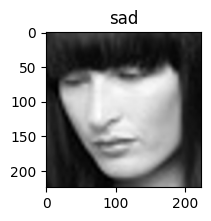

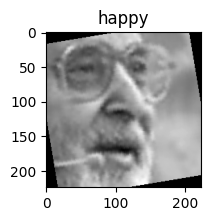

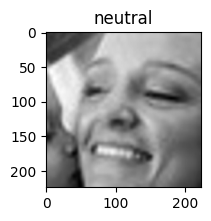

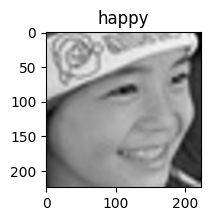

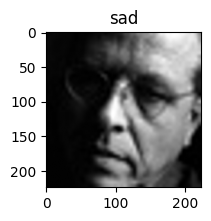

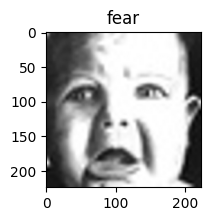

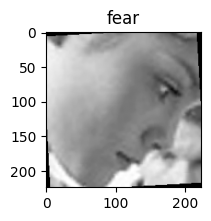

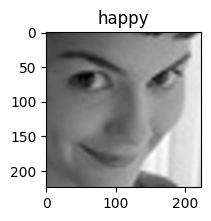

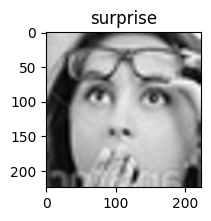

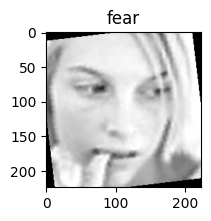

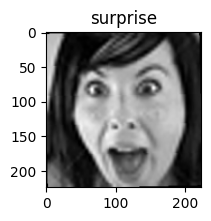

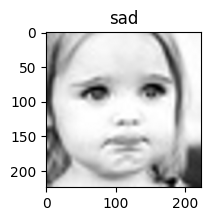

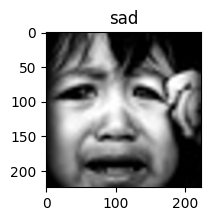

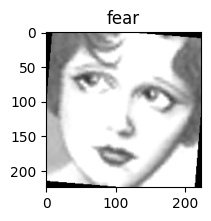

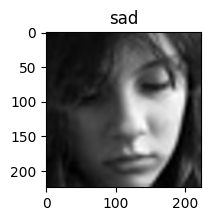

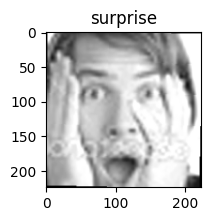

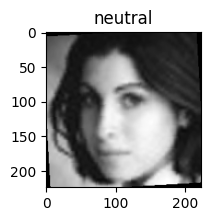

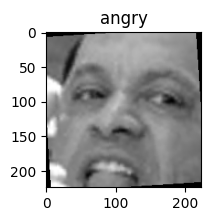

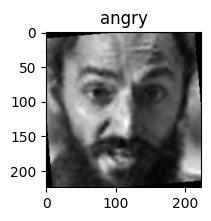

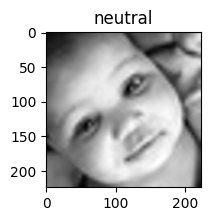

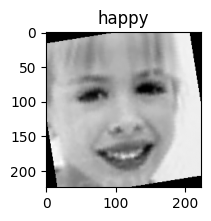

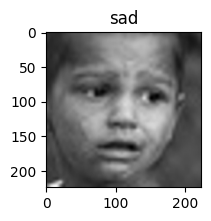

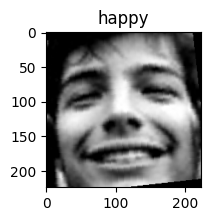

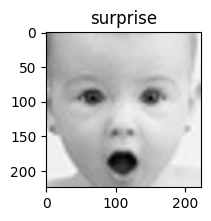

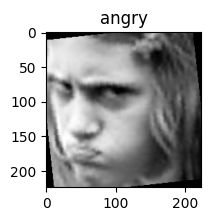

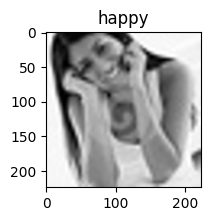

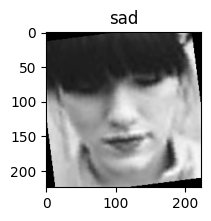

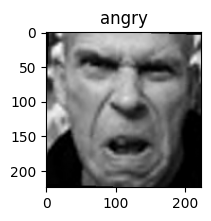

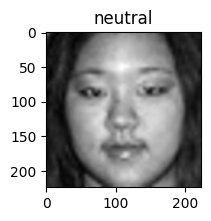

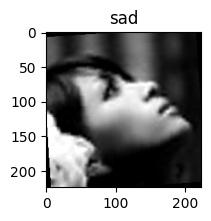

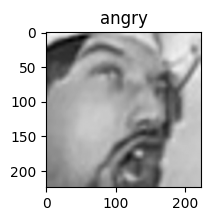

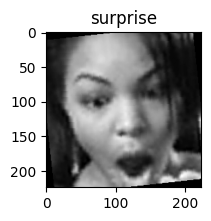

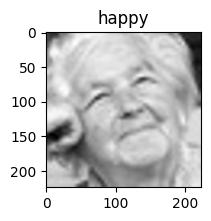

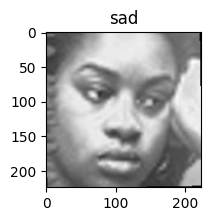

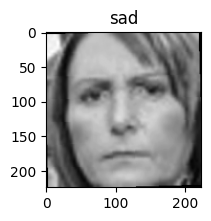

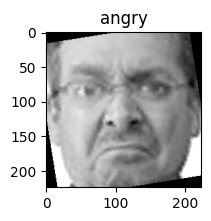

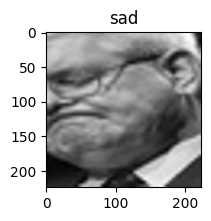

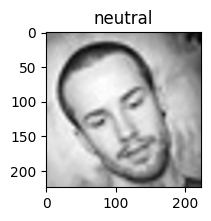

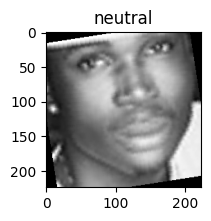

In [14]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    fig, ax = plt.subplots(figsize=(2,4))
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.show()
    plt.pause(0.001)

for x_item, y_item in zip(batch_data, batch_labels):
    show_input(x_item, title=class_names[y_item])

In [15]:
total_objs = sum(class_counts.values())
weights = torch.zeros(len(class_names))
for i, cl in enumerate(class_names):
    weights[i]=total_objs/class_counts[cl]
    weights[i] = weights[i] / 10
weights

tensor([0.7218, 6.6010, 0.7025, 0.4023, 0.5785, 0.5836, 0.8992])

# Init model

In [16]:
n_classes = len(class_names)
model = CustomResnet18(n_classes)
# model = CustomMobilenetv3small(n_classes)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = "cpu"
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()# weight=weights)
# loss.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Train model

In [17]:
from copy import deepcopy


def train_model(model, loss, optimizer, scheduler, num_epochs):
    train_loss = torch.zeros(num_epochs)
    val_loss = torch.zeros(num_epochs)
    train_acc = torch.zeros(num_epochs)
    val_acc = torch.zeros(num_epochs)
    best_acc = 0
    best_model = deepcopy(model)
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            if phase == 'train':
                train_loss[epoch] = epoch_loss
                train_acc[epoch] = epoch_acc
            else:
                val_loss[epoch] = epoch_loss
                val_acc[epoch] = epoch_acc
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model = deepcopy(model)
                    print('new best model!', flush=True)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return train_loss, val_loss, train_acc, val_acc, best_model


def validate_model(model, loss_f, dataloader, device: str):
    total_loss = 0
    model.eval()
    model.to(device)
    running_acc = 0
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            preds = model(inputs)
            preds_class = preds.argmax(dim=1)
            running_acc += (preds_class == labels.data).float().mean()
            loss_value = loss_f(preds, labels)
            total_loss += loss_value.item()
    acc = running_acc / len(dataloader)
    mean_loss = total_loss / len(dataloader)
    print('Loss: {:.4f} acc: {:.4f}'.format(mean_loss, acc), flush=True)


def get_preds_labels(model, loss_f, dataloader, device: str) -> tuple:
    model.eval()
    model.to(device)
    model_preds = []
    target_labels = []
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            preds = model(inputs)
            preds_class = preds.argmax(dim=1)
            model_preds.extend(preds_class.ravel().tolist())
            target_labels.extend(labels.ravel().tolist())
            
    return model_preds, target_labels

In [18]:
len(train_dataloader.dataset)

25942

In [19]:
num_epochs=30
train_loss, val_loss, train_acc, val_acc, model = train_model(model, loss, optimizer, scheduler, num_epochs=num_epochs)

Epoch 0/19:


D:\Python\Environments\python312_main_venv\Lib\site-packages\torch\optim\lr_scheduler.py:182: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
100%|████████████████████████████████████████████████████████████████████████████████| 406/406 [03:41<00:00,  1.84it/s]

train Loss: 1.1864 Acc: 0.5483



100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [01:10<00:00,  1.58it/s]

new best model!
val Loss: 1.1219 Acc: 0.5693
Epoch 1/19:



100%|████████████████████████████████████████████████████████████████████████████████| 406/406 [04:36<00:00,  1.47it/s]

train Loss: 1.0147 Acc: 0.6183



100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [03:11<00:00,  1.73s/it]


new best model!
val Loss: 1.0554 Acc: 0.6134
Epoch 2/19:


100%|████████████████████████████████████████████████████████████████████████████████| 406/406 [07:50<00:00,  1.16s/it]


train Loss: 0.9315 Acc: 0.6519


100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [01:47<00:00,  1.03it/s]

new best model!
val Loss: 0.9614 Acc: 0.6458
Epoch 3/19:



100%|████████████████████████████████████████████████████████████████████████████████| 406/406 [07:29<00:00,  1.11s/it]

train Loss: 0.8700 Acc: 0.6747



100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [01:38<00:00,  1.13it/s]

new best model!
val Loss: 0.9414 Acc: 0.6582
Epoch 4/19:



100%|████████████████████████████████████████████████████████████████████████████████| 406/406 [07:22<00:00,  1.09s/it]

train Loss: 0.7301 Acc: 0.7287



100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [01:37<00:00,  1.14it/s]

new best model!
val Loss: 0.9047 Acc: 0.6724
Epoch 5/19:



100%|████████████████████████████████████████████████████████████████████████████████| 406/406 [07:21<00:00,  1.09s/it]

train Loss: 0.6558 Acc: 0.7583



100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [01:37<00:00,  1.14it/s]

val Loss: 0.9413 Acc: 0.6671
Epoch 6/19:



100%|████████████████████████████████████████████████████████████████████████████████| 406/406 [07:20<00:00,  1.09s/it]

train Loss: 0.5953 Acc: 0.7812



100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [01:31<00:00,  1.21it/s]

new best model!
val Loss: 0.9850 Acc: 0.6735
Epoch 7/19:



100%|████████████████████████████████████████████████████████████████████████████████| 406/406 [07:21<00:00,  1.09s/it]

train Loss: 0.5190 Acc: 0.8110



100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [01:34<00:00,  1.18it/s]

val Loss: 1.0420 Acc: 0.6734
Epoch 8/19:



100%|████████████████████████████████████████████████████████████████████████████████| 406/406 [07:17<00:00,  1.08s/it]

train Loss: 0.4541 Acc: 0.8369



100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [01:30<00:00,  1.22it/s]

val Loss: 1.0612 Acc: 0.6640
Epoch 9/19:



100%|████████████████████████████████████████████████████████████████████████████████| 406/406 [07:14<00:00,  1.07s/it]

train Loss: 0.3203 Acc: 0.8882



100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [01:32<00:00,  1.20it/s]

new best model!
val Loss: 1.1549 Acc: 0.6827
Epoch 10/19:



100%|████████████████████████████████████████████████████████████████████████████████| 406/406 [07:12<00:00,  1.06s/it]

train Loss: 0.2615 Acc: 0.9105



100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [01:32<00:00,  1.20it/s]

val Loss: 1.2479 Acc: 0.6761
Epoch 11/19:



100%|████████████████████████████████████████████████████████████████████████████████| 406/406 [07:15<00:00,  1.07s/it]

train Loss: 0.2246 Acc: 0.9230



100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [01:32<00:00,  1.20it/s]

val Loss: 1.2965 Acc: 0.6810
Epoch 12/19:



100%|████████████████████████████████████████████████████████████████████████████████| 406/406 [07:16<00:00,  1.08s/it]

train Loss: 0.1910 Acc: 0.9353



100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [01:31<00:00,  1.22it/s]

val Loss: 1.3839 Acc: 0.6783
Epoch 13/19:



100%|████████████████████████████████████████████████████████████████████████████████| 406/406 [07:15<00:00,  1.07s/it]

train Loss: 0.1742 Acc: 0.9407



100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [01:32<00:00,  1.20it/s]

val Loss: 1.5094 Acc: 0.6707
Epoch 14/19:



100%|████████████████████████████████████████████████████████████████████████████████| 406/406 [07:16<00:00,  1.07s/it]

train Loss: 0.1331 Acc: 0.9563



100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [01:33<00:00,  1.18it/s]

new best model!
val Loss: 1.4727 Acc: 0.6851
Epoch 15/19:



100%|████████████████████████████████████████████████████████████████████████████████| 406/406 [07:21<00:00,  1.09s/it]

train Loss: 0.1167 Acc: 0.9604



100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [01:41<00:00,  1.10it/s]

val Loss: 1.5264 Acc: 0.6792
Epoch 16/19:



100%|████████████████████████████████████████████████████████████████████████████████| 406/406 [07:20<00:00,  1.08s/it]

train Loss: 0.1041 Acc: 0.9655



100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [01:36<00:00,  1.15it/s]

val Loss: 1.5533 Acc: 0.6813
Epoch 17/19:



100%|████████████████████████████████████████████████████████████████████████████████| 406/406 [07:30<00:00,  1.11s/it]

train Loss: 0.0930 Acc: 0.9697



100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [01:34<00:00,  1.18it/s]

new best model!
val Loss: 1.6009 Acc: 0.6857
Epoch 18/19:



100%|████████████████████████████████████████████████████████████████████████████████| 406/406 [07:15<00:00,  1.07s/it]

train Loss: 0.0854 Acc: 0.9731



100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [01:33<00:00,  1.18it/s]

val Loss: 1.6440 Acc: 0.6811
Epoch 19/19:



100%|████████████████████████████████████████████████████████████████████████████████| 406/406 [07:23<00:00,  1.09s/it]

train Loss: 0.0746 Acc: 0.9756



100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [01:32<00:00,  1.20it/s]

new best model!
val Loss: 1.6389 Acc: 0.6878


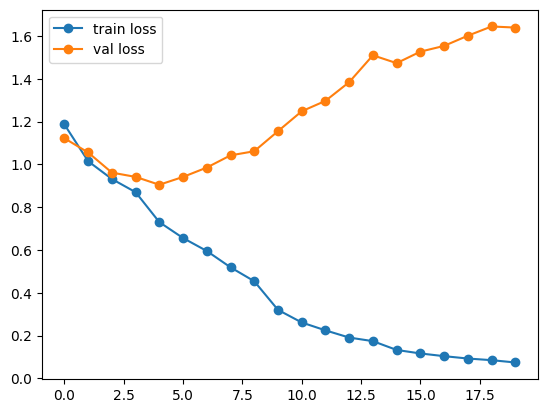

In [20]:
plt.plot(train_loss, label = 'train loss', marker='o')
plt.plot(val_loss, label = 'val loss', marker='o')
plt.legend(loc='best')
plt.show()

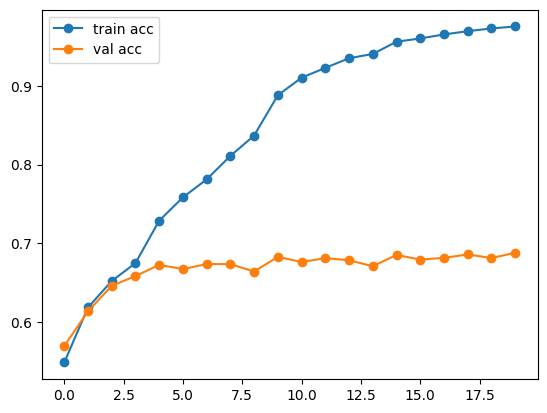

In [21]:
plt.plot(train_acc, label = 'train acc', marker='o')
plt.plot(val_acc, label = 'val acc', marker='o')
plt.legend(loc='best')
plt.show()

# Model's perfromance analysis

In [22]:
val_preds, val_labels = get_preds_labels(model, loss, val_dataloader, device)

100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [01:31<00:00,  1.21it/s]


In [23]:
test_preds, test_labels = get_preds_labels(model, loss, test_dataloader, device)

100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:59<00:00,  1.33s/it]


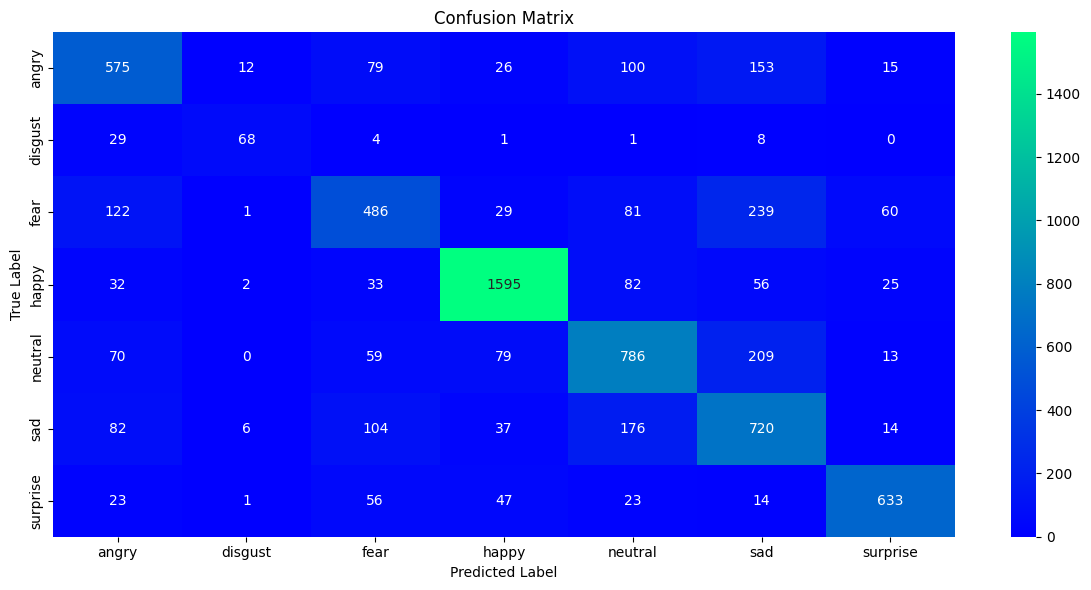

In [24]:
def plot_conf_matrix(labels, preds):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(12, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="winter",xticklabels=class_names,yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

plot_conf_matrix(val_labels, val_preds)

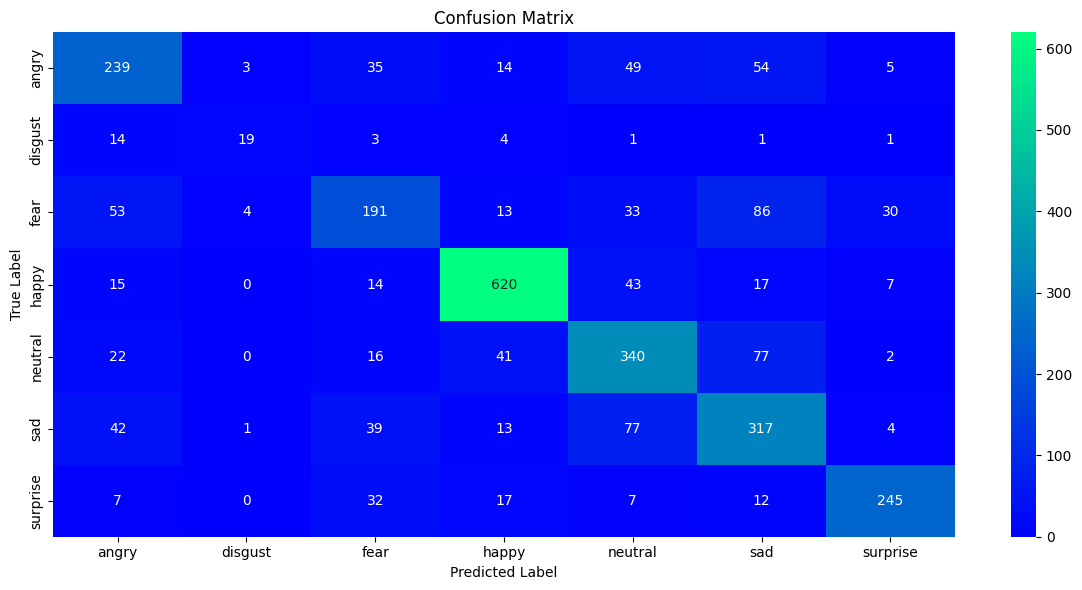

In [25]:
plot_conf_matrix(test_labels, test_preds)

In [26]:
print(classification_report(val_labels, val_preds, target_names=class_names))

              precision    recall  f1-score   support

       angry       0.62      0.60      0.61       960
     disgust       0.76      0.61      0.68       111
        fear       0.59      0.48      0.53      1018
       happy       0.88      0.87      0.88      1825
     neutral       0.63      0.65      0.64      1216
         sad       0.51      0.63      0.57      1139
    surprise       0.83      0.79      0.81       797

    accuracy                           0.69      7066
   macro avg       0.69      0.66      0.67      7066
weighted avg       0.69      0.69      0.69      7066



In [27]:
print(classification_report(test_labels, test_preds, target_names=class_names))

              precision    recall  f1-score   support

       angry       0.61      0.60      0.60       399
     disgust       0.70      0.44      0.54        43
        fear       0.58      0.47      0.52       410
       happy       0.86      0.87      0.86       716
     neutral       0.62      0.68      0.65       498
         sad       0.56      0.64      0.60       493
    surprise       0.83      0.77      0.80       320

    accuracy                           0.68      2879
   macro avg       0.68      0.64      0.65      2879
weighted avg       0.69      0.68      0.68      2879



C:\Users\IlshatGuestAccount\AppData\Local\Temp\ipykernel_14784\3660744395.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_cl = torch.nn.functional.softmax(pred.float()).data.cpu().numpy().argmax(axis=0)


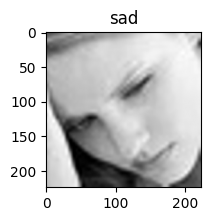

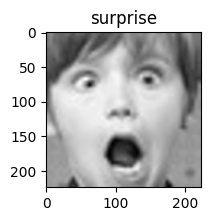

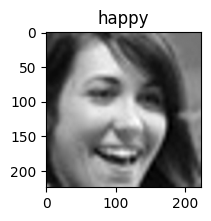

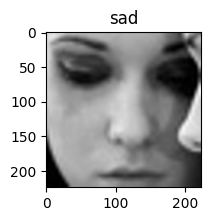

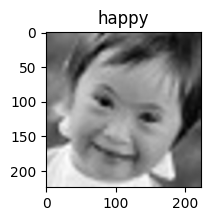

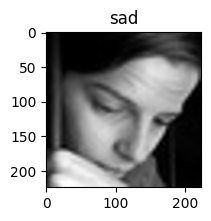

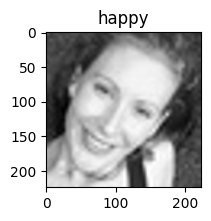

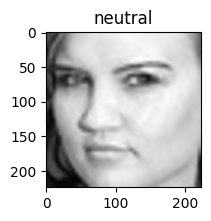

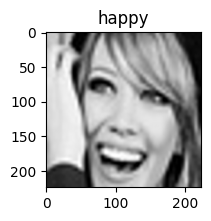

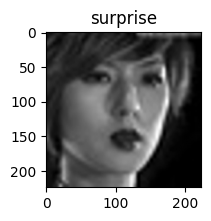

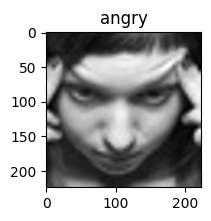

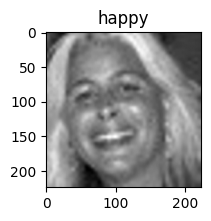

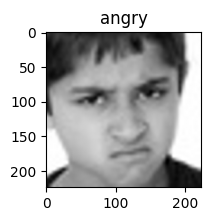

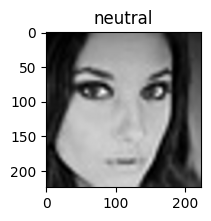

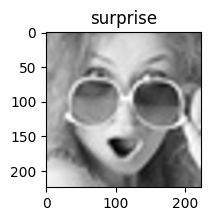

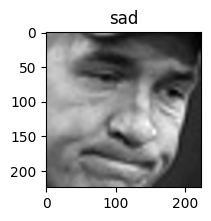

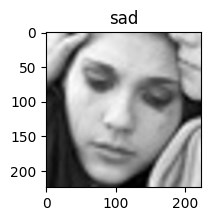

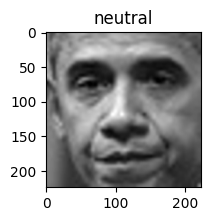

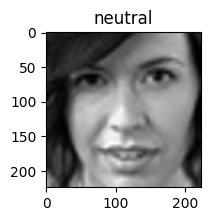

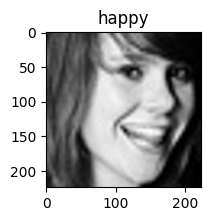

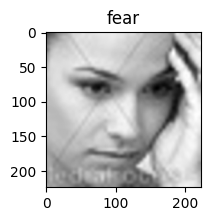

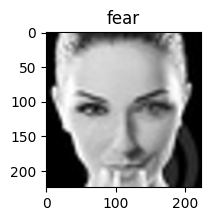

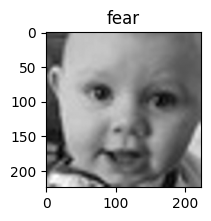

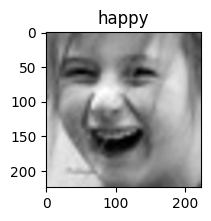

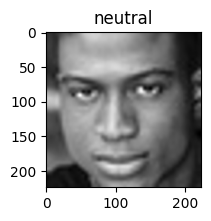

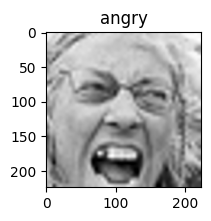

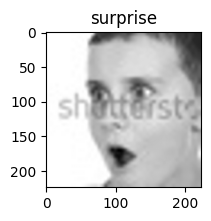

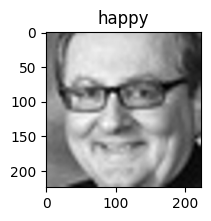

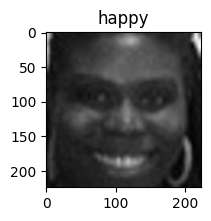

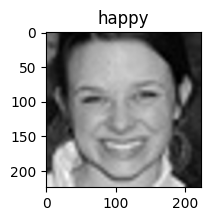

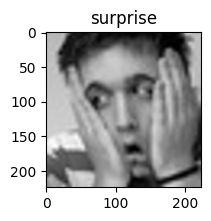

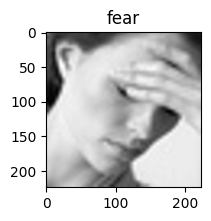

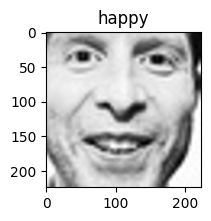

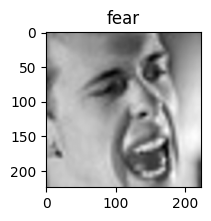

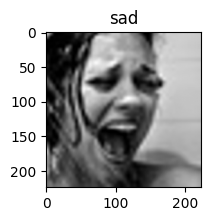

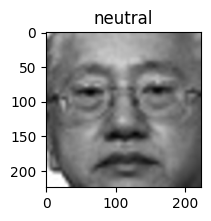

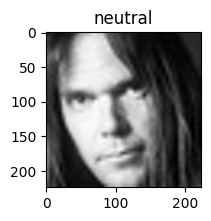

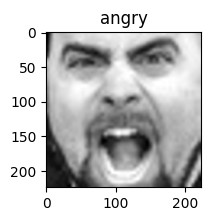

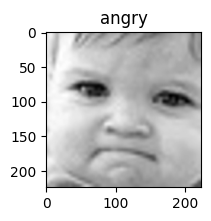

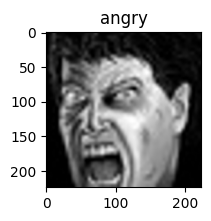

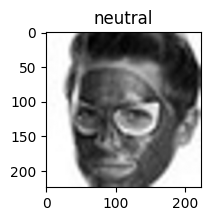

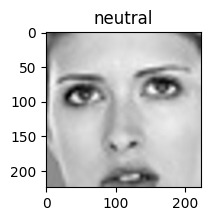

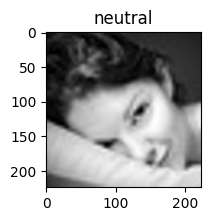

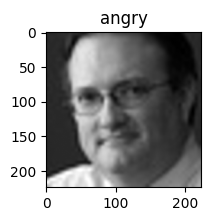

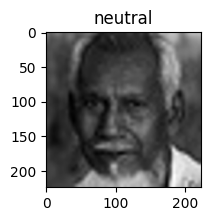

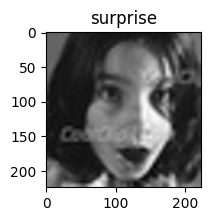

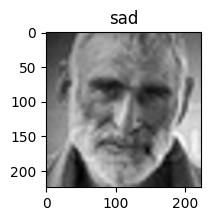

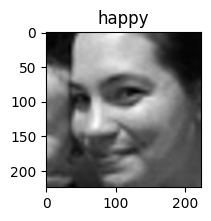

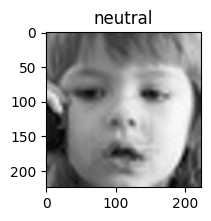

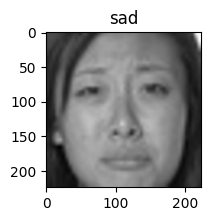

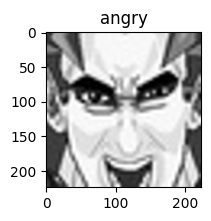

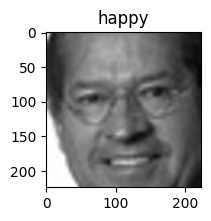

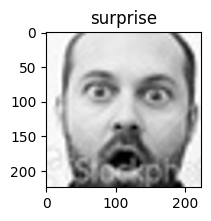

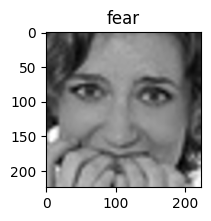

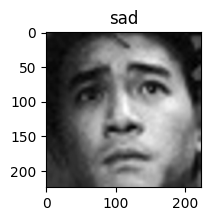

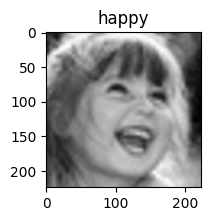

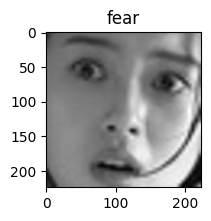

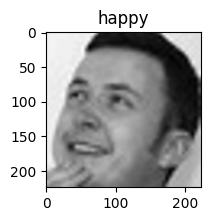

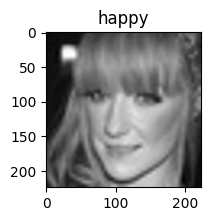

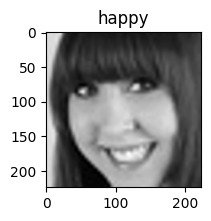

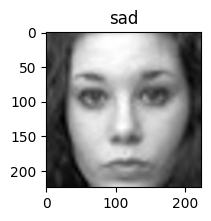

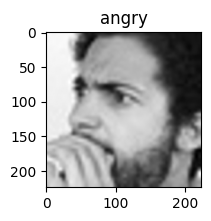

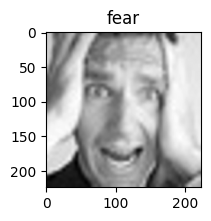

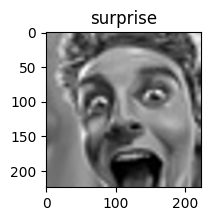

In [28]:
model.to('cpu')

batch_data, batch_labels = next(iter(val_dataloader))

with torch.set_grad_enabled(False):
    preds = model(batch_data)
    
for img, pred in zip(batch_data, preds):
    pred_cl = torch.nn.functional.softmax(pred.float()).data.cpu().numpy().argmax(axis=0)
    img = img.cpu()
    show_input(img, title=class_names[pred_cl])

In [29]:
# model_name = 'mobilenet_fer'
model_name = 'resnet18_fer'
onnx_model_path = os.path.join('SavedModels', f'{model_name}.onnx')
torch_model_path = os.path.join('SavedModels', f'{model_name}.pt')

# Save models

In [30]:
model.to('cpu')
torch.save(model, torch_model_path)

In [31]:
torch.onnx.export(
    model,
    batch_data[0].unsqueeze(0),
    onnx_model_path,
    export_params=True,  # Export trained parameter weights
    opset_version=16,    # ONNX operator set version
    do_constant_folding=True, # Optimize constants in the graph
    input_names=['input'],   # Name for the input node
    output_names=['output'], # Name for the output node
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}} # Allow dynamic batch size
)

In [32]:
import json

config = {'class_names' : class_names,
          'img_size' : img_size,
          'inp_size' : batch_data[0].unsqueeze(0).shape,
          'mean': mean,
          'std': std,
          'onnx_model_path': onnx_model_path,
          'torch_model_path': torch_model_path
         }

with open(os.path.join('SavedModels', 'config.json'),'w') as f:
    json.dump(config, f, indent=4)